In [2]:
import pandas as pd
import pyarrow.parquet as pq
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.fftpack import fft, ifft
import scipy.integrate as integrate

from tqdm import trange
import gc
import seaborn as sns
from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from scipy import fftpack

from bokeh.plotting import figure,show,output_file, ColumnDataSource
from bokeh.io import push_notebook, output_notebook
from bokeh.layouts import column

from sklearn.model_selection import KFold
import lightgbm as lgb

import peakutils

from numpy.fft import rfft, rfftfreq, irfft
from sklearn.metrics import matthews_corrcoef as mcc


output_notebook()

Loading BokehJS ...

In [3]:
%%time
meta_train = pd.read_csv('input/metadata_train.csv')
raw_train = pq.read_pandas('input/train.parquet').to_pandas()

CPU times: user 1min 47s, sys: 53.2 s, total: 2min 40s
Wall time: 50.5 s


In [4]:
R = 0.02 #range of data sample in seconds
N_measurements = 8e5 #number of measurements in one cycle
D_0 = R/N_measurements #how often the signal is sampled


print('Sampling delta: {} ns'.format(D_0 * 1e9))
print('Sampling frequency: {} MHz'.format(1/(D_0 * 1e6)))
print('\n')
print('Nyquist frequency (f_max): {} MHz'.format(1/(D_0 * 1e6)/2))
print('Min frequency (f_min and also minimum discernible frequency gap): {} Hz'.format(1/R))

Sampling delta: 25.0 ns
Sampling frequency: 40.0 MHz


Nyquist frequency (f_max): 20.0 MHz
Min frequency (f_min and also minimum discernible frequency gap): 50.0 Hz


In [8]:
def fft_peaks(time_series, buckets = 100, stdevs = 0.7):
    FFT = abs(fftpack.fft(time_series))
    FFT[FFT < FFT.std() * stdevs] = 0
    
    freq_range = FFT.shape[0]//2
    buck_size = int(np.ceil((freq_range)/(buckets)))
    
    segments = [(i,i+buck_size) for i in range(0, freq_range, buck_size)]
    fft_components = [np.sum(FFT[ind_[0]:ind_[1]]) for ind_ in segments]
    fft_compunents = [(item/max(fft_components))*100 for item in fft_components]
    fft_ranges = [(int(ind_[0]*5e-2), int(ind_[1]*5e-2)) for ind_ in segments]
    
    return fft_components, fft_ranges
    

In [9]:
def generate_fourier_dataset(train_set, meta_train, buckets):
    train_length = meta_train.shape[0]
    positive_length = len(meta_train[meta_train.target == 1])
    hand_features = ['mean','max','min','std']
    
    dataset = np.zeros((train_length, len(hand_features) + buckets + 3))
    imbalance_ = positive_length / train_length
    
    row_index = 0
    for i in trange(train_length):
#         if meta_train.loc[i, 'target'] == 1 or (random.random() < imbalance_):
        spectrum = train_set[str(i)]

        fft_integrals, fft_ranges = fft_peaks(spectrum, buckets)

        features_temp = np.array([spectrum.mean(), spectrum.max(), spectrum.min(), spectrum.std()] 
                            + fft_integrals)

        label_temp = meta_train.loc[i, 'target']
        measurement_id = meta_train.loc[i, 'id_measurement']
        phase = meta_train.loc[i, 'phase']
        
        dataset[row_index,:] = np.concatenate([features_temp, [measurement_id, phase, label_temp]])

        row_index += 1
    
    
    #discard zeros
    tmp_ = np.sum(dataset, axis=1)
    nzv = len(tmp_[tmp_ != 0])
    
    return pd.DataFrame(columns= hand_features + ['ft_' + str(ran[1]) + str('GHz') for ran in fft_ranges] 
                        + ['measurement_id', 'phase', 'label'], 
                        data = dataset[0:nzv,:])

In [26]:
def generate_fourier_dataset_test(test_set, meta_test, buckets):
    test_length = meta_test.shape[0]
    hand_features = ['mean','max','min','std']
    
    dataset = np.zeros((test_length, len(hand_features) + buckets + 2))
    
    row_index = 0
    for i in trange(test_length):
        spectrum = test_set[str(i + 8712)]

        fft_integrals, fft_ranges = fft_peaks(spectrum, buckets)

        features_temp = np.array([spectrum.mean(), spectrum.max(), spectrum.min(), spectrum.std()] 
                            + fft_integrals)
        measurement_id = meta_test.loc[i, 'id_measurement']
        phase = meta_test.loc[i, 'phase']
        
        dataset[row_index,:] = np.concatenate([features_temp, [measurement_id, phase]])

        row_index += 1
        
    return pd.DataFrame(columns= hand_features + ['ft_' + str(ran[1]) + str('GHz') for ran in fft_ranges]
                        + ['measurement_id', 'phase'], 
                        data = dataset)

In [11]:
%%time
train = generate_fourier_dataset(raw_train, meta_train, 60)


print('Train length: {}'.format(len(train)))
print('Positive length: {}'.format(len(train[train.label == 1])))


100%|██████████| 8712/8712 [08:47<00:00, 16.50it/s]

Train length: 8712
Positive length: 525
CPU times: user 7min 56s, sys: 43.8 s, total: 8min 40s
Wall time: 8min 47s


In [12]:
from imblearn.over_sampling import SMOTE

In [13]:
smote_algo = SMOTE(random_state = 3)
smote_data_X, smote_data_Y = smote_algo.fit_sample(train.drop(['label'], axis = 1), train['label'])
smote_data_X = pd.DataFrame(data = smote_data_X, columns=train.drop(['label'], axis = 1).columns)
smote_data_Y = pd.DataFrame(data = smote_data_Y, columns =['label'])
smote_data = smote_data_X
smote_data['label'] = smote_data_Y['label']

In [17]:
def my_err_rate(y_hat, dtrain):
    y = dtrain.get_label()
    y_hat = np.round(y_hat)
    MCC = mcc(y, y_hat)
    return 'MCC', MCC, True

In [18]:
x_train = smote_data.copy()
target = smote_data['label']
input_target = x_train['label']
x_train.drop(['label'], axis=1, inplace=True)
features = x_train.columns
param = {'num_leaves': 90,
         'min_data_in_leaf': 80, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.05,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 2,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "random_state": 164,
         "verbosity": -1}
max_iter=7


In [19]:
folds = KFold(n_splits=7, shuffle=True, random_state=19)
oof = np.zeros(len(x_train))
feature_importance_df = pd.DataFrame()
score = [0 for _ in range(folds.n_splits)]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train.values, target.values)):
    print("Fold No.{}".format(fold_+1))
    trn_data = lgb.Dataset(x_train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx])
    val_data = lgb.Dataset(x_train.iloc[val_idx][features],
                           label=target.iloc[val_idx])
    num_round = 15000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = val_data,
                    feval = my_err_rate,
                    verbose_eval=100,
                    early_stopping_rounds = 50)
    
    oof[val_idx] = clf.predict(x_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    score[fold_] = metrics.roc_auc_score(target.iloc[val_idx], oof[val_idx])
    if fold_ == max_iter - 1: break
        

if (folds.n_splits == max_iter):
    print("CV score: {:<8.5f}".format(metrics.roc_auc_score(target, oof)))
    print("MCC score: {:<8.5f}".format(mcc(target, np.round(oof))))
else:
     print("CV score: {:<8.5f}".format(sum(score) / max_iter))

Fold No.1
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's auc: 0.998769	valid_0's MCC: 0.958341
[200]	valid_0's auc: 0.999614	valid_0's MCC: 0.978691
[300]	valid_0's auc: 0.999761	valid_0's MCC: 0.982956
Early stopping, best iteration is:
[343]	valid_0's auc: 0.999791	valid_0's MCC: 0.987195
Fold No.2
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's auc: 0.998015	valid_0's MCC: 0.950493
[200]	valid_0's auc: 0.999301	valid_0's MCC: 0.971786
Early stopping, best iteration is:
[195]	valid_0's auc: 0.999273	valid_0's MCC: 0.973496
Fold No.3
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's auc: 0.999028	valid_0's MCC: 0.963575
[200]	valid_0's auc: 0.999765	valid_0's MCC: 0.98639
Early stopping, best iteration is:
[224]	valid_0's auc: 0.999803	valid_0's MCC: 0.988928
Fold No.4
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's auc: 0.998523	valid_0's MCC: 0.959926
[200]	valid_0'

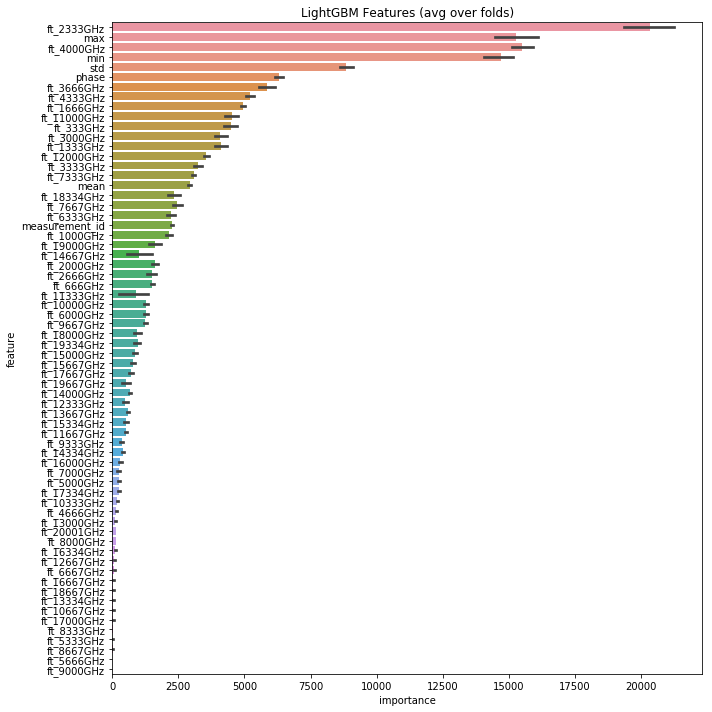

In [20]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(10,10))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [21]:
gc.collect()

13458

# Predict and Submit

In [22]:
%%time
meta_test = pd.read_csv('input/metadata_test.csv')

CPU times: user 8.51 ms, sys: 4.6 ms, total: 13.1 ms
Wall time: 12 ms


In [23]:
%%time
meta_test = pd.read_csv('input/metadata_test.csv')
subset_test = pq.read_pandas('input/test.parquet').to_pandas()

CPU times: user 4min 16s, sys: 2min 2s, total: 6min 18s
Wall time: 2min 11s


In [27]:
%%time
test = generate_fourier_dataset_test(subset_test, meta_test, 60)
print('Train length: {}'.format(len(test)))


100%|██████████| 20337/20337 [32:46<00:00, 12.91it/s]     

Train length: 20337
CPU times: user 19min 11s, sys: 2min 20s, total: 21min 32s
Wall time: 32min 46s


In [28]:
test.to_csv("test.csv", index=False)

In [29]:
x_filename = meta_test.signal_id
predictions = clf.predict(test, num_iteration=clf.best_iteration)

In [30]:
sub_df = pd.DataFrame({"signal_id":x_filename.values})
sub_df["target"] = pd.Series(predictions).round()
sub_df['signal_id'] = sub_df['signal_id'].astype(np.int64)
sub_df['target'] = sub_df['target'].astype(np.int64)
sub_df.to_csv("submission_five.csv", index=False)
sub_df

,signal_id,target
0,8712,0
1,8713,0
2,8714,0
3,8715,0
4,8716,0
5,8717,0
6,8718,0
7,8719,0
8,8720,0
9,8721,0


In [31]:
positive = len(sub_df[sub_df["target"] == 1])
print('Predicted positive: {}. {}% of total.'.format(positive, positive/len(sub_df)*100))

Predicted positive: 91. 0.4474602940453361% of total.
